# Creating Date-Partitioned Tables in BigQuery

GSP414

https://www.cloudskillsboost.google/focuses/3694?parent=catalog

## Overview
BigQuery is Google's fully managed, NoOps, low cost analytics database. With BigQuery you can query terabytes and terabytes of data without having any infrastructure to manage or needing a database administrator. BigQuery uses SQL and can take advantage of the pay-as-you-go model. BigQuery allows you to focus on analyzing data to find meaningful insights.

The dataset you'll use is an ecommerce dataset that has millions of Google Analytics records for the Google Merchandise Store loaded into BigQuery. You have a copy of that dataset for this lab and will explore the available fields and row for insights.

In this lab you will query partitioned datasets and create your own dataset partitions to improve query performance and reduce cost.


# Create a new dataset
First, you will create a dataset to store your tables.

Click the three dots next to your Qwiklabs project ID and select `Create dataset`.

Name your dataset `ecommerce`. Leave the other options at their default values (Data Location, Default table Expiration).

Click `Create dataset`.

# Creating tables with date partitions
A partitioned table is a table that is divided into segments, called partitions, that make it easier to manage and query your data. By dividing a large table into smaller partitions, you can improve query performance, and control costs by reducing the number of bytes read by a query.

Now you will create a new table and bind a date or timestamp column as a partition. Before we do that, let's explore the data in the non-partitioned table first.

### Query webpage analytics for a sample of visitors in 2017
In the Query Editor, add the below query. Before running, note the total amount of data it will process as indicated next to the query validator icon: "This query will process 1.74 GB when run".

In [ ]:
#standardSQL
SELECT DISTINCT
  fullVisitorId,
  date,
  city,
  pageTitle
FROM `data-to-insights.ecommerce.all_sessions_raw`
WHERE date = '20170708'
LIMIT 5

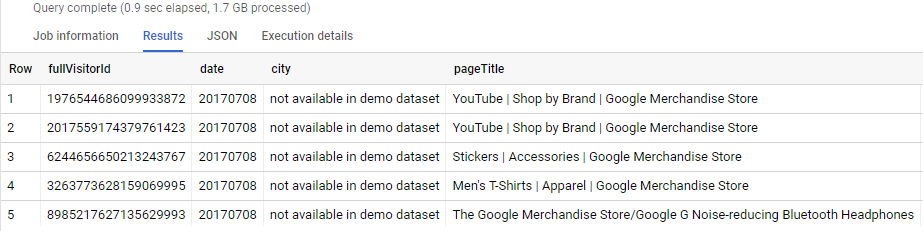

### Query webpage analytics for a sample of visitors in 2018
Let's modify the query to look at visitors for 2018 now.

Click COMPOSE NEW QUERY to clear the Query Editor, then add this new query. Note the `WHERE date` parameter is changed to `20180708`:

In [ ]:
#standardSQL
SELECT DISTINCT
  fullVisitorId,
  date,
  city,
  pageTitle
FROM `data-to-insights.ecommerce.all_sessions_raw`
WHERE date = '20180708'
LIMIT 5

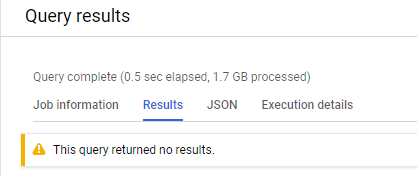

**Notice that the query still processes 1.74 GB even though it returns 0 results. Why? The query engine needs to scan all records in the dataset to see if they satisfy the date matching condition in the WHERE clause. It must look at each record to compare the date against the condition of ‘20180708'.**

**Additionally, the LIMIT 5 does not reduce the total amount of data processed, which is a common misconception.**

# Common use-cases for date-partitioned tables
Scanning through the entire dataset everytime to compare rows against a WHERE condition is wasteful. This is especially true if you only really care about records for a specific period of time like:

- All transactions for the last year
- All visitor interactions within the last 7 days
- All products sold in the last month

Instead of scanning the entire dataset and filtering on a date field like we did in the earlier queries, we will now setup a date-partitioned table. This will allow us to completely ignore scanning records in certain partitions if they are irrelevant to our query.

# Create a new partitioned table based on date

In [ ]:
#standardSQL
 CREATE OR REPLACE TABLE ecommerce.partition_by_day
 PARTITION BY date_formatted
 OPTIONS(
   description="a table partitioned by date"
 ) AS
 SELECT DISTINCT
 PARSE_DATE("%Y%m%d", date) AS date_formatted,
 fullvisitorId
 FROM `data-to-insights.ecommerce.all_sessions_raw`

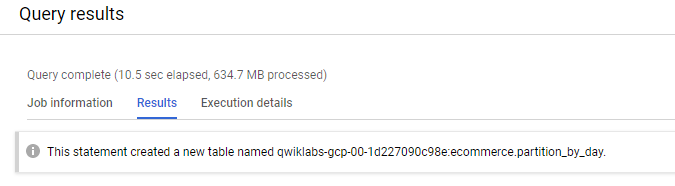

In this query, note the new option - `PARTITION BY` a field. The two options available to partition are DATE and TIMESTAMP. The `PARSE_DATE` function is used on the date field (stored as a string) to get it into the proper DATE type for partitioning.

Click on the `ecommerce` dataset, then select the new `partiton_by_day` table:

Click on the Details tab.

Confirm that you see:

- Partitioned by: Day
- Partitioning on: date_formatted

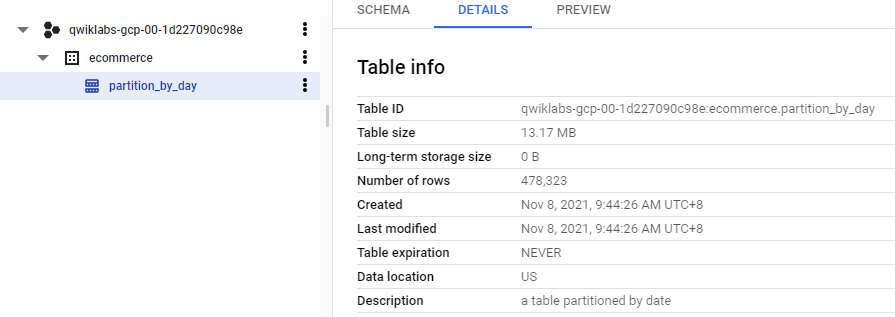

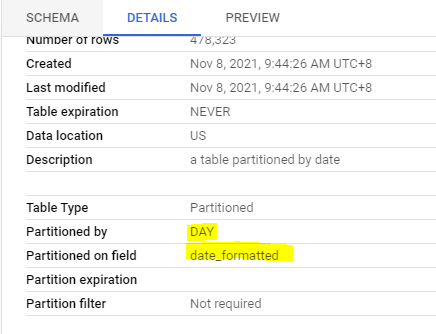

**Note:**

*Partitions within partitioned tables on your Qwiklabs account will auto-expire after 60 days from the value in your date column. Your personal Google Cloud account with billing-enabled will let you have partitioned tables that don't expire. For the purposes of this lab, the remaining queries will be ran against partitioned tables that have already been created.*

## View data processed with a partitioned table
Run the below query, and note the total bytes to be processed. This time 25 KB or 0.025MB is processed, which is a fraction of what you queried.

In [ ]:
#standardSQL
SELECT *
FROM `data-to-insights.ecommerce.partition_by_day`
WHERE date_formatted = '2016-08-01'



Now run the below query, and note the total bytes to be processed. You should see `This query will process 0 B when run`.

In [ ]:
#standardSQL
SELECT *
FROM `data-to-insights.ecommerce.partition_by_day`
WHERE date_formatted = '2018-07-08'

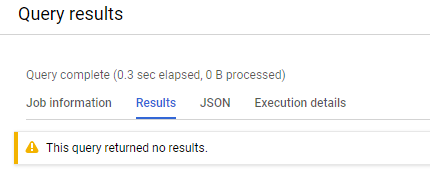

# Creating an auto-expiring partitioned table
Auto-expiring partitioned tables are used to comply with data privacy statutes, and can be used to avoid unnecessary storage (which you'll be charged for in a production environment). If you want to create a rolling window of data, add an expiration date so the partition disappears after you're finished using it.

## Explore the available NOAA weather data tables
In the left menu, in Explorer, click on `Add Data` and select `Explore public datasets`.

Search for "GSOD NOAA" then select the dataset.

Click on `View Dataset`.

Scroll through the tables in the `noaa_gsod` dataset (which are manually sharded and not partitioned)

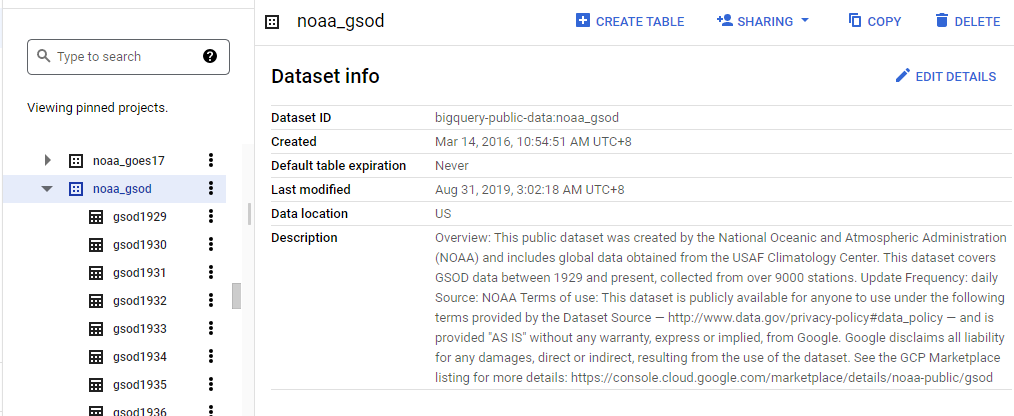


Your goal is to create a table that:

- Queries on weather data from 2018 onward
- Filters to only include days that have had some precipitation (rain, snow, etc.)
- Only stores each partition of data for 90 days from that partition's date (rolling window)



In [ ]:
#standardSQL
 SELECT
   DATE(CAST(year AS INT64), CAST(mo AS INT64), CAST(da AS INT64)) AS date,
   (SELECT ANY_VALUE(name) FROM `bigquery-public-data.noaa_gsod.stations` AS stations
    WHERE stations.usaf = stn) AS station_name,  -- Stations may have multiple names
   prcp
 FROM `bigquery-public-data.noaa_gsod.gsod*` AS weather
 WHERE prcp < 99.9  -- Filter unknown values
   AND prcp > 0     -- Filter stations/days with no precipitation
   AND CAST(_TABLE_SUFFIX AS int64) >= 2018
 ORDER BY date DESC -- Where has it rained/snowed recently
 LIMIT 10

Note that the table wildcard * used in the `FROM` clause to limit the amount of tables referred to in the `TABLE_SUFFIX` filter.

Note that although a `LIMIT 10` was added, this still does not reduce the total amount of data scanned (about 1.83 GB) since there are no partitions yet.

Click Run.

Confirm the date is properly formatted and the precipitation field is showing non-zero values.

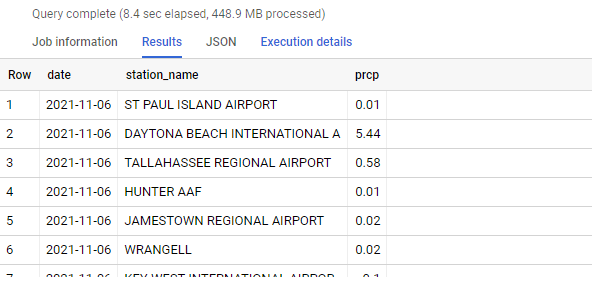

# Create a Partitioned Table
Modify the previous query to create a table with the below specifications:

- Table name: `ecommerce.days_with_rain`
- Use the date field as your `PARTITION BY`
- For `OPTIONS`, specify `partition_expiration_days = 60`
- Add the table description = "weather stations with precipitation, partitioned by day"

Your query should look like this:

In [ ]:
#standardSQL
 CREATE OR REPLACE TABLE ecommerce.days_with_rain
 PARTITION BY date
 OPTIONS (
   partition_expiration_days=60,
   description="weather stations with precipitation, partitioned by day"
 ) AS
 SELECT
   DATE(CAST(year AS INT64), CAST(mo AS INT64), CAST(da AS INT64)) AS date,
   (SELECT ANY_VALUE(name) FROM `bigquery-public-data.noaa_gsod.stations` AS stations
    WHERE stations.usaf = stn) AS station_name,  -- Stations may have multiple names
   prcp
 FROM `bigquery-public-data.noaa_gsod.gsod*` AS weather
 WHERE prcp < 99.9   -- Filter unknown values
   AND prcp > 0      -- Filter
   AND CAST(_TABLE_SUFFIX AS int64) >= 2018

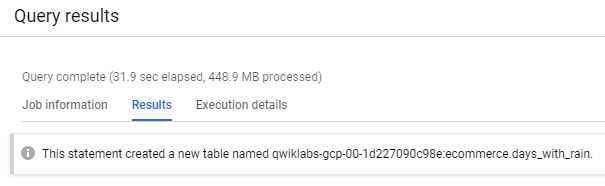

## Confirm data partition expiration is working
To confirm you are only storing data from 60 days in the past up until today, run the `DATE_DIFF` query to get the age of your partitions, which are set to expire after 60 days.

Below is a query which tracks the average rainfall for the NOAA weather station in Wakayama, Japan which has significant precipitation.

Add this query and run it:

In [ ]:
#standardSQL
# avg monthly precipitation
SELECT
  AVG(prcp) AS average,
  station_name,
  date,
  CURRENT_DATE() AS today,
  DATE_DIFF(CURRENT_DATE(), date, DAY) AS partition_age,
  EXTRACT(MONTH FROM date) AS month
FROM ecommerce.days_with_rain
WHERE station_name = 'WAKAYAMA' #Japan
GROUP BY station_name, date, today, month, partition_age
ORDER BY date DESC;             # most recent days first

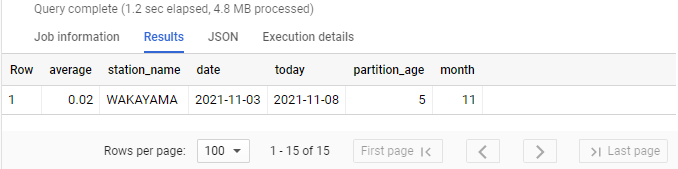

# Confirm the oldest `partition_age` is at or below 60 days
Update the `ORDER BY` clause to show the oldest partitions first. The date you see there Add this query and run it:

In [ ]:
#standardSQL
# avg monthly precipitation
SELECT
  AVG(prcp) AS average,
  station_name,
  date,
  CURRENT_DATE() AS today,
  DATE_DIFF(CURRENT_DATE(), date, DAY) AS partition_age,
  EXTRACT(MONTH FROM date) AS month
FROM ecommerce.days_with_rain
WHERE station_name = 'WAKAYAMA' #Japan
GROUP BY station_name, date, today, month, partition_age
ORDER BY partition_age DESC

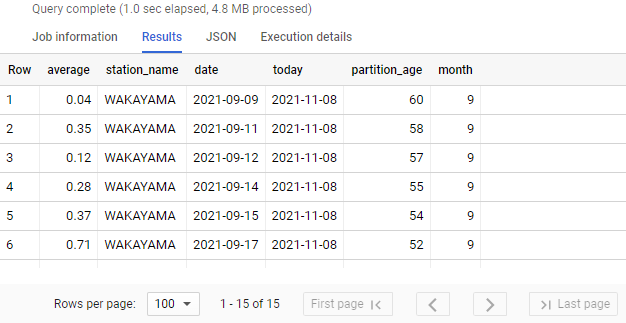